# **Natural Language Processing with Disaster Tweets**

### **1.Introduction**

#### In this work i will use:
* **Pandas** is used for data manipulation and analysis
* **NumPy** is used for numerical operations, especially arrays
* **Seaborn** is used for statistical data visualization

#### For Natural Language Processing:
* **SnowballStemmer** - reducing words to their root form
* **Stopwords** provides a list of common words (like 'the', 'is')
* **Cleantext** is a package for cleaning text
* **Tokenizer** to convert text to sequences of integers
* **Keras** is the high-level neural network API used with TensorFlow for building deep learning models

#### **Recurrent Neural Network (RNN)**
class of neural networks designed for processing sequential data, such as time series or text. Unlike traditional feedforward neural networks, RNNs have connections that loop back, allowing them to maintain a "memory" of previous inputs in the sequence.

#### **LSTM (Long Short-Term Memory)**
special type of Recurrent Neural Network (RNN) that is specifically designed to handle long-range dependencies in sequential data. It mitigates the vanishing gradient problem that simple RNNs encounter, making it more capable of capturing long-term dependencies.

#### Importing essential libraries for data processing and model building

In [1]:
import pandas as pd  
import numpy as np   

# Visualization libraries
import seaborn as sns 
import matplotlib.pyplot as plt

# Natural Language Processing (NLP) libraries
from nltk.stem import SnowballStemmer 
from nltk.corpus import stopwords 

# Text cleaning library
from cleantext import clean

# Tokenization and padding for text preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer  
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Neural network libraries (Keras and TensorFlow)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout  
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.layers import LSTM, Bidirectional 
import keras as keras


from sklearn.model_selection import train_test_split 

###  
### **2. Import data**

#### Import train data

In [2]:
train_data=pd.read_csv("./data/train.csv")

#### Import test data

In [3]:
test_data=pd.read_csv("./data/test.csv")

###  
### **3. EDA**

In [4]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
print(f"Train data has {train_data.shape[0]} rows and {train_data.shape[1]} columns.")

Train data has 7613 rows and 5 columns.


In [6]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
print(f"Test data has {test_data.shape[0]} rows and {test_data.shape[1]} columns.")

Test data has 3263 rows and 4 columns.


In [8]:
# train data describe
train_data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [9]:
# test data describe
test_data.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


####  
#### **Check null values:**

In [10]:
print(f"Train data null values: \n \n{train_data.isnull().sum()}")

Train data null values: 
 
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [11]:
print(f"Test data null values: \n \n{test_data.isnull().sum()}")

Test data null values: 
 
id             0
keyword       26
location    1105
text           0
dtype: int64


####  
#### **Check duplicates**

In [12]:
num_duplicates = train_data.duplicated().sum()
if num_duplicates == 0:
    print("There are no duplicates in train data.")
else:
    print(f"{num_duplicates} duplicates found in train data.")

There are no duplicates in train data.


In [13]:
num_duplicates = test_data.duplicated().sum()
if num_duplicates == 0:
    print("There are no duplicates in test data.")
else:
    print(f"{num_duplicates} duplicates found in test data.")

There are no duplicates in test data.


####  
#### **Check distribution:**

<Axes: xlabel='target', ylabel='count'>

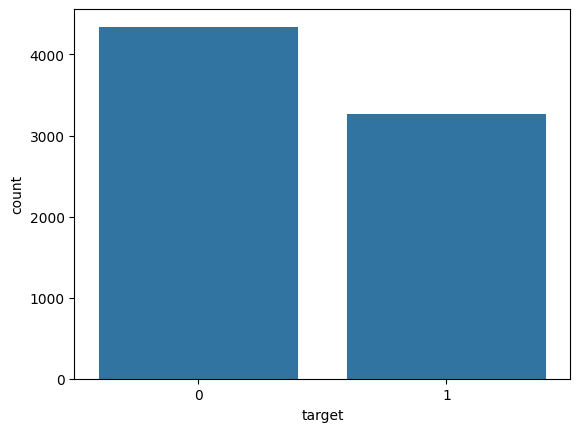

In [14]:
sns.countplot(data=train_data, x = "target")

#### **Conclusion:** the data is slightly unbalanced

###  
### **Cleaning data**

#### Drop 'id', 'keyword' and 'location' columns to train an RNN only on text data.


In [15]:
test_ids = test_data["id"]

train_data = train_data.drop(['id', 'keyword', 'location'], axis=1)
test_data = test_data.drop(['id', 'keyword', 'location'], axis=1)

####  
#### This feature is designed to preprocess text data by removing unnecessary elements and standardizing the text, which can be useful before using the text in machine learning models. Such transformations help the model focus on important text features without being distracted by noise, such as URLs or numbers:

In [16]:
def clean_text(text):
    text = clean(text,
                 lower=True,                                  # Convert to lowercase
                 no_urls=True,  # Remove URLs
                 no_emails=True,  # Remove emails
                 no_phone_numbers=True,  # Remove phone numbers
                 no_numbers=True,                             # Remove numbers
                 no_digits=True,                              # Remove digits
                 no_punct=True,                               # Remove punctuation
                 no_emoji=True,                               # Remove emojy
                 replace_with_url="<url>",  # Replace URL with a placeholder
                 replace_with_email="<email>",  # Replace email with a placeholder
                 replace_with_phone_number="<phone_number>",  # Replace phone number with a placeholder
                 )
    return text

####  
#### **Stemming:** Reducing words to their base forms reduces the number of unique words in the text, which can improve the performance of machine learning models.

#### **Stop Word Filtering:** Removing stop words reduces noise in the data, allowing the model to focus on more meaningful words.

In [17]:
stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

def stem_words(sentence):
    words = sentence.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    
    return ' '.join(words)

In [18]:
def clean_data(data):
    data['text'] = data['text'].apply(clean_text)
    data['text'] = data['text'].apply(stem_words)

    return data['text']


In [19]:
train_data['text'] = clean_data(train_data)
test_data['text'] = clean_data(test_data)

train_data['text'].head().values


array(['deed reason earthquak may allah forgiv us',
       'forest fire near la rong sask canada',
       'resid ask shelter place notifi offic evacu shelter place order expect',
       '<number> peopl receiv wildfir evacu order california',
       'got sent photo rubi alaska smoke wildfir pour school'],
      dtype=object)

#### This is an example of cleared text

####  
#### **Tokenizer**

#### is used to convert text data into numerical sequences, which is necessary for training machine learning models, especially neural networks.

In [20]:
new_train_data = train_data.drop(['target'], axis=1)

In [21]:
all_tweets = pd.concat([new_train_data, test_data], ignore_index=True)

In [22]:
all_tweets.head()

,text
0,deed reason earthquak may allah forgiv us
1,forest fire near la rong sask canada
2,resid ask shelter place notifi offic evacu she...
3,<number> peopl receiv wildfir evacu order cali...
4,got sent photo rubi alaska smoke wildfir pour ...


In [23]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(all_tweets['text'])

In [24]:
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

In [25]:
max_length = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in test_sequences))

In [26]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

train_data_tocken = train_data.copy()
train_data_tocken['text'] = list(train_padded)

test_data_tocken = test_data.copy()
test_data_tocken['text'] = list(test_padded)

print(train_data_tocken.head())
print(test_data_tocken.head())

                                                text  target
0  [4695, 458, 222, 108, 1666, 1958, 17, 0, 0, 0,...       1
1  [121, 4, 109, 712, 6746, 6747, 1127, 0, 0, 0, ...       1
2  [1252, 480, 1811, 427, 6748, 231, 47, 1811, 42...       1
3  [2, 13, 1667, 101, 47, 323, 57, 0, 0, 0, 0, 0,...       1
4  [52, 1317, 150, 3701, 1812, 205, 101, 2415, 15...       1
                                                text
0  [164, 1323, 58, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1  [326, 222, 876, 146, 450, 1012, 217, 0, 0, 0, ...
2  [121, 4, 634, 2163, 14534, 3301, 757, 414, 119...
3  [328, 298, 4818, 101, 0, 0, 0, 0, 0, 0, 0, 0, ...
4  [454, 595, 16, 2, 383, 1117, 0, 0, 0, 0, 0, 0,...


####  
### **RNN**

####  RNN (Recurrent Neural Network) is a type of neural network that is used to work with sequential data such as text, time series, audio, and video. Unlike traditional neural networks, RNNs have loops that allow information to persist, providing the ability to consider previous elements of a sequence when processing the current one.

In [27]:
vocab_size = len(tokenizer.word_index) + 1
embed_units=100
hidden_units=128
callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)

# model creation
model_RNN=Sequential()

# to transform word indices into dense vectors
model_RNN.add(Embedding(vocab_size, embed_units))

# Adding a simple RNN layer with 128 neurons
model_RNN.add(SimpleRNN(hidden_units))

# Dropout layer to prevent overfitting
model_RNN.add(Dropout(0.2))

# Adding a RNN layer with 256 neurons
model_RNN.add(Dense(256, activation='relu'))

# Dropout layer to prevent overfitting
model_RNN.add(Dropout(0.2))

# Single neuron output layer with sigmoid activation for binary classification
model_RNN.add(Dense(1, activation='sigmoid'))

model_RNN.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
# how much the network weights are updated at each training step
learning_rate = 0.0001

# Compiling the model
model_RNN.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

* train_padded: Padded sequences from the training dataset.
* train_data['target'].values: Target labels for binary classification.
* batch_size=200: Determines how many samples will be processed before updating the model parameters.
* epochs=7: Specifies that the model will go through the entire training set 7 times.
* validation_split=0.2: 20% of the data is used to test the model's performance during training.
* callbacks=[callbacks]: Enables early stopping to prevent overfitting if the model stops improving on the validation data.

In [29]:
model_RNN_hist = model_RNN.fit(train_padded, 
                           train_data['target'].values, 
                           batch_size=200, 
                           epochs=7, 
                           validation_split=0.2,
                           callbacks=[callbacks])

Epoch 1/7
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.6036 - loss: 0.6452 - val_accuracy: 0.7564 - val_loss: 0.5108
Epoch 2/7
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8779 - loss: 0.3253 - val_accuracy: 0.7321 - val_loss: 0.5464
Epoch 3/7
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9462 - loss: 0.1593 - val_accuracy: 0.7406 - val_loss: 0.5994
Epoch 3: early stopping


Early stopping was activated after the third epoch because the val_loss metric (validation loss) started to increase, which is a sign that the model is starting to overfit.
Usually, if the validation metrics start to get worse while improving on the training data, this signals overfitting, and early stopping helps to avoid further deterioration.



In [30]:
model_LSTM = Sequential()

# embedding layer
model_LSTM.add(Embedding(vocab_size, embed_units))

# idirectional LSTM layer
model_LSTM.add(Bidirectional(LSTM(hidden_units)))

# Dropout to reduce overfitting
model_LSTM.add(Dropout(0.2))

# ADense layer
model_LSTM.add(Dense(256, activation='relu'))

# Dropout - to reduce overfitting
model_LSTM.add(Dropout(0.2))

# Aoutput layer with sigmoid for binary classification
model_LSTM.add(Dense(1, activation='sigmoid'))

# model summary
model_LSTM.summary()

# Compile
learning_rate = 0.0001
model_LSTM.compile(loss='binary_crossentropy',
                     optimizer=Adam(learning_rate),
                     metrics=['accuracy'])

# Train the model
model_LSTM_history = model_LSTM.fit(train_padded, 
                                train_data['target'].values, 
                                batch_size=200, 
                                epochs=7, 
                                validation_split=0.2,
                                callbacks=[callbacks])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.5647 - loss: 0.6892 - val_accuracy: 0.5345 - val_loss: 0.6880
Epoch 2/7
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.5887 - loss: 0.6734 - val_accuracy: 0.5345 - val_loss: 0.6822
Epoch 3/7
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.5738 - loss: 0.6661 - val_accuracy: 0.5469 - val_loss: 0.6629
Epoch 4/7
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.6539 - loss: 0.6217 - val_accuracy: 0.7026 - val_loss: 0.6068
Epoch 5/7
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.7666 - loss: 0.5452 - val_accuracy: 0.7518 - val_loss: 0.5326
Epoch 6/7
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.8224 - loss: 0.4318 - val_accuracy: 0.7695 - val_loss: 0.4917
Epoch 7/7
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.8617 - loss: 0.3435 - val_accuracy: 0.7978 - val_loss: 0.4591


Epochs 1-3: The model is trained, but the accuracy and validation loss have not improved significantly. This is common at the beginning of training.

Epochs 4-6: Halfway through training, the model starts to improve significantly, as seen by the fact that the accuracy on the training and validation data increases sharply. The loss decreases, and the accuracy on the validation data increases at each step.

Epoch 7: The model finishes training with good results on both the training and validation data. The accuracy on the validation data has reached 80%, which is a good result for many problems.

###  
### **Save data**

In [31]:
predictions = model_RNN.predict(test_padded)

final_predictions = (predictions > 0.5).astype(int)

results_df = pd.DataFrame({"id": test_ids, "target": final_predictions.flatten()})

results_df.to_csv("predictions.csv", index=False)

print("Predictions have been written to 'predictions.csv'")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Predictions have been written to 'predictions.csv'
